In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = 'data/'

data = pd.read_csv(DATA_PATH + 'p2-arbres-fr.csv', sep=';')

# Nettoyage des données

## Quelle variable pour l'espèce d'arbre ?

In [68]:
genre_na = data.genre.isna().sum()
genre_unique = data.genre.unique().shape
print(f"La variable 'Genre' a {genre_na} valeurs manquantes pour {genre_unique} valeurs uniques.")

espece_na = data.espece.isna().sum()
espece_unique = data.espece.unique().shape
print(f"La variable 'espece' a {espece_na} valeurs manquantes pour {espece_unique} valeurs uniques.")

variete_na = data.variete.isna().sum()
variete_unique = data.variete.unique().shape
print(f"La variable 'variete' a {variete_na} valeurs manquantes pour {variete_unique} valeurs uniques.")

La variable 'Genre' a 16 valeurs manquantes pour (176,) valeurs uniques.
La variable 'espece' a 1752 valeurs manquantes pour (540,) valeurs uniques.
La variable 'variete' a 163360 valeurs manquantes pour (437,) valeurs uniques.


La variable Genre comporte le moins de valeurs manquantes et le moins de valeurs uniques, ce qui rend l'analyse de la répartition des arbres plus pertinente et pratique. 

## Valeurs aberrantes 

### Hauteur

In [69]:
data.hauteur_m.sort_values(ascending=False).iloc[:20]

182852    881818
150101      5155
152110      2525
101985      2015
152205      1815
147984      1610
152437      1515
152238      1515
151382      1515
153314      1514
147229      1512
96481       1511
152339      1510
5392        1510
168580      1216
68681       1211
158359      1113
107327      1010
153036       818
151364       815
Name: hauteur_m, dtype: int64

In [70]:
data[data.hauteur_m > 30].shape

(573, 18)

On constate que beaucoup de valeurs de la variable hauteur_m sont aberrantes, aucun arbre ne fait jusqu'à 1km de haut, pas même 200m. 

Nos recherches ont montré que la taille maximale d'un arbre à Paris est 30m, et le nombre d'observations supérieures à ce nombre est négligeable face au total d'arbre dans la ville. Cependant, nous partons de l'hypothèse que les employés chargés des mesures ont rentrés les données en centimètres, et non pas en mètres. Afin de conserver ces données, nous avons décidé d'isoler les arbres de plus de 30m étant marqués comme juvéniles ou jeune adultes (J ou JA dans la variable stade_developpement) et de diviser leur hauteur par 100.


In [71]:
mask = ((data.hauteur_m > 30) & (data.stade_developpement.isin(['J', 'JA'])))
data[mask].shape

(355, 18)

355 valeurs ont donc pu être conservées, le reste est considéré comme non-significatif. Pour éviter les valeurs aberrantes, on supprime les 120 arbres malgré tout d'une taille supérieure à 50m

In [79]:
data.loc[mask, 'hauteur_m'] = data.loc[mask, 'hauteur_m'] / 100
data = data[(data.hauteur_m < 50)]

(199656, 18)

### Circonférence

Malheureusement, la circonférence varie beaucoup plus d'une espèce à l'autre, un cyprès peut être immense et très fin en comparaison d'un platane de même taille. 

C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='circonference_cm'>

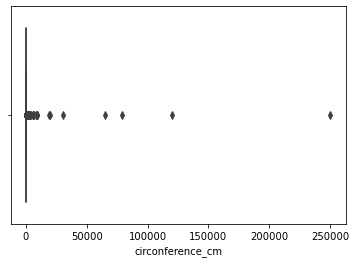

In [80]:
sns.boxplot(data.circonference_cm)

In [81]:
data.shape

(199656, 18)

In [84]:
data.circonference_cm.sort_values(ascending=False)[:20]

149056    250255
160432    120170
173343     79120
147634     65110
91256      30140
90605      20130
71787      18589
147235      9155
164616      9095
152303      9085
103437      9035
97354       8110
148106      6595
170367      6125
148481      6120
163918      6085
133546      4090
167606      3630
152046      3120
198023      2750
Name: circonference_cm, dtype: int64

In [87]:
4090 % 5

0

Cela-dit, on peut-être certains qu'aucun arbre ne fait plus de 15m de diamètre.

In [88]:
data[(data.circonference_cm < ].shape

(176365, 18)

In [50]:
data.isna().mean()

id                     0.000000
type_emplacement       0.000000
domanialite            0.000000
arrondissement         0.000000
complement_addresse    0.892958
numero                 1.000000
lieu                   0.000000
id_emplacement         0.000000
libelle_francais       0.000000
genre                  0.000000
espece                 0.000000
variete                0.943662
circonference_cm       0.000000
hauteur_m              0.000000
stade_developpement    0.000000
remarquable            0.002817
geo_point_2d_a         0.000000
geo_point_2d_b         0.000000
dtype: float64

In [5]:
# Variables redondantes et presque vides
# On garde genre plutot que libelle car il y a plus de données et moins de modalités

var_inutiles = ['lieu', 'id_emplacement', 'type_emplacement']
var_vides = ['complement_addresse', 'numero', 'espece', 'variete', 'libelle_francais']
var_drop = var_inutiles + var_vides

df = data.drop(var_drop, axis=1)
# Formattage de la colonne remarquable
df['remarquable'] = df.remarquable.isna()


# Extraction des données pour l'analyse

In [6]:
# Extraction de datasets
from sklearn.preprocessing import OneHotEncoder

# Coordonnées 
data_geo = df[['geo_point_2d_a', 'geo_point_2d_b']]

# Dominalité
dom_list = ['Alignement', 'Jardin', 'CIMETIERE']

temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
temp = temp[temp.domanialite.isin(dom_list)]

new_name = {0: 'Alignement',
         1: 'CIMETIERE', 
         2: 'Jardin'}

dom = temp[['circonference_cm', 'hauteur_m', 'domanialite']].dropna()
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_dom = pd.DataFrame(encoder.fit_transform(dom[['domanialite']]).toarray())
final_dom = dom.join(encoder_dom)
final_dom.rename(columns = new_name, inplace = True)

# Age de l'arbre
temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
dev = temp[['circonference_cm', 'hauteur_m', 'stade_developpement']].dropna()

dev['A'] = dev['stade_developpement'] == 'A'
dev['J'] = dev['stade_developpement'] == 'J'
dev['M'] = dev['stade_developpement'] == 'M'
dev['JA'] = dev['stade_developpement'] == 'JA'

# Repartition en fonction de la domanialité

align = df[df['domanialite'] == 'Alignement']
jardin = df[df['domanialite'] == 'Jardin']
cimetiere = df[df['domanialite'] == 'CIMETIERE']

# Domanialité vs stade de développement

temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
full = temp[['stade_developpement', 'domanialite']].dropna()

full['A'] = full['stade_developpement'] == 'A'
full['J'] = full['stade_developpement'] == 'J'
full['M'] = full['stade_developpement'] == 'M'
full['JA'] = full['stade_developpement'] == 'JA'
full['Alignement'] = full['domanialite'] == 'Alignement'
full['Cimetière'] = full['domanialite'] == 'CIMETIERE'
full['Jardin'] = full['domanialite'] == 'Jardin'

In [7]:
full

,stade_developpement,domanialite,A,J,M,JA,Alignement,Cimetière,Jardin
1,A,Jardin,True,False,False,False,False,False,True
2,A,Jardin,True,False,False,False,False,False,True
3,A,Jardin,True,False,False,False,False,False,True
8,A,Jardin,True,False,False,False,False,False,True
9,A,Jardin,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
198859,J,DJS,False,True,False,False,False,False,False
198860,J,Jardin,False,True,False,False,False,False,True
198861,JA,Jardin,False,False,False,True,False,False,True
198862,JA,Jardin,False,False,False,True,False,False,True


# Data explo

## Domanialite

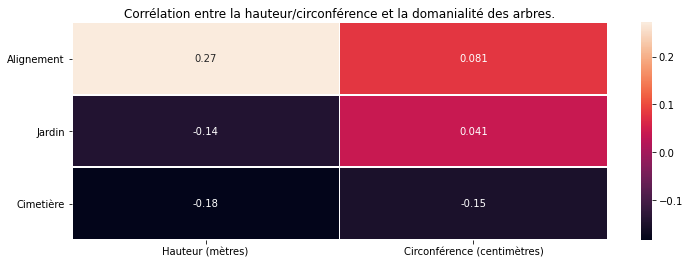

In [8]:
cr = final_dom.corr()
final_cr = cr.loc[['Alignement', 'Jardin', 'CIMETIERE'], ['hauteur_m', 'circonference_cm']]
plot = sns.heatmap(final_cr, annot=True, linewidths=.7)
plot.set_xticklabels(['Hauteur (mètres)', 'Circonférence (centimètres)'])
plot.set_yticklabels(['Alignement', 'Jardin', 'Cimetière'])
plot.set_title('Corrélation entre la hauteur/circonférence et la domanialité des arbres.')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Domanialité_taille_corr.png')

Correlation plus difficile à trouver avec la circonference qu'avec la hauteur.
Il ya un vrai lien entre l'usage de l'arbre et ses caractéristiques.

## Stade de développement

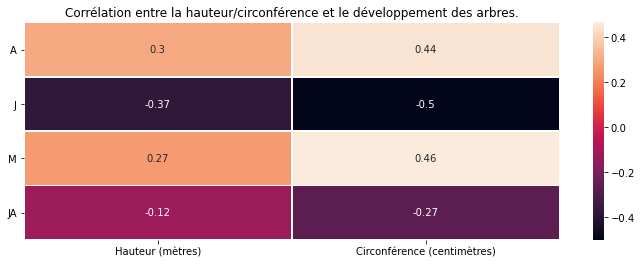

In [9]:
cr = dev.corr()
final_cr = cr.loc[['A', 'J', 'M', 'JA'], ['hauteur_m', 'circonference_cm']]
plot = sns.heatmap(final_cr, annot=True, linewidths=.7)
plot.set_title('Corrélation entre la hauteur/circonférence et le développement des arbres.')
plot.set_xticklabels(['Hauteur (mètres)', 'Circonférence (centimètres)'])

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Développement_taille_corr.png')

J > JA > M > A

## Stade de développement vs domanialité

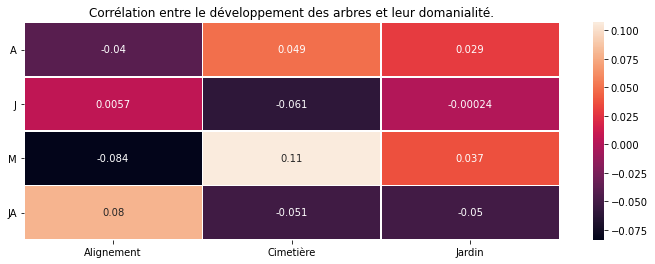

In [10]:
cr = full.corr().loc[['A', 'J', 'M', 'JA'], ['Alignement', 'Cimetière', 'Jardin']]

plot = sns.heatmap(cr, annot=True, linewidths=.7)
plot.set_title('Corrélation entre le développement des arbres et leur domanialité.')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Développement_domanialité_corr.png')

## Domanialité vs espèces

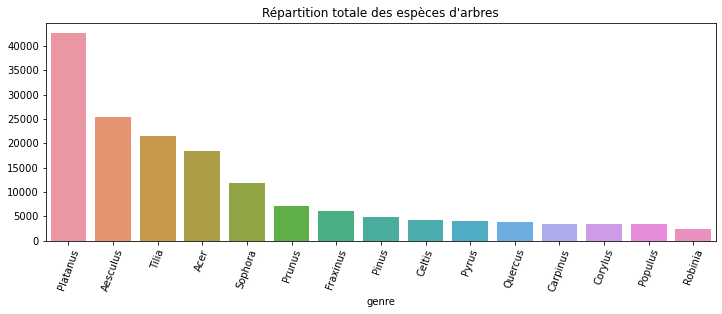

In [11]:
# Repartition totale des espèces

temp = df.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
most_trees = temp.index.to_list()
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition totale des espèces d'arbres")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/genre_répartition.png')

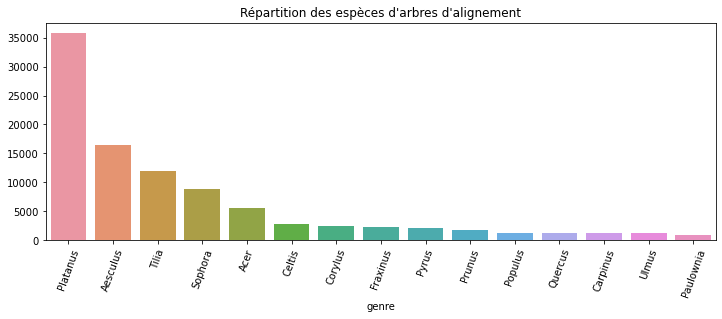

In [12]:
# Répartition des alignements

temp = align.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition des espèces d'arbres d'alignement")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/alignement_genre_répartition.png')

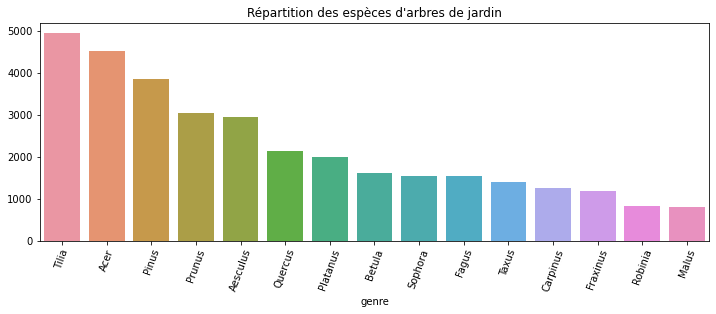

In [13]:
# Répartition des jardins

temp = jardin.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition des espèces d'arbres de jardin")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/jardin_genre_répartition.png')

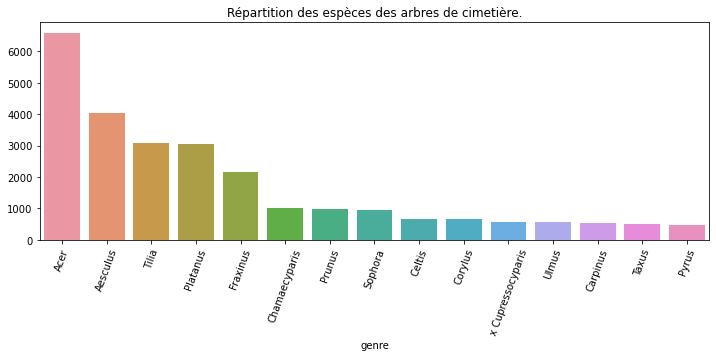

In [14]:
# Répartition des cimetières

temp = cimetiere.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set_title('Répartition des espèces des arbres de cimetière.')

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/cimetière_genre_répartition.png')